In [193]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_tensor_type(torch.FloatTensor)
#MLP
class MLP(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(MLP,self).__init__()
        self.MLP = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU()
        )
    
    def forward(self,x):
        output = self.MLP(x)
        return output

import dgl

gcn_message = dgl.function.copy_src('v_feature','msg') 
def gcn_reduce(nodes):
    #agg_feature = torch.max(nodes.mailbox['msg'], dim=1)
    return {'v_feature': torch.max(nodes.mailbox['msg'], dim=1)[0]} #rel agg

#GCN
class GCNLayer(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GCNLayer,self).__init__()
    
    def forward(self,g,inputs):
        g.ndata['v_feature'] = inputs
        g.send(g.edges(),gcn_message)
        g.recv(g.nodes(),gcn_reduce)
        v_feature = g.ndata.pop('v_feature')
        return torch.cat([inputs,v_feature],dim = 1)

#Subgraph
class SubNetwork(nn.Module):
    def __init__(self,in_feats,hidden_size,layernums):
        super(SubNetwork,self).__init__()
        self.encoder = []
        self.gcnlayer = []
        self.layernums = layernums
        input_size = in_feats
        for i in range(0,layernums):
            if i == 0:
                self.encoder.append(MLP(input_size,hidden_size))
            else:
                self.encoder.append(MLP(hidden_size*2,hidden_size))
            self.gcnlayer.append(GCNLayer(hidden_size,hidden_size*2))
    
    def forward(self,g,inputs):
        v_feature = inputs
        for i in range(self.layernums):
            v_feature = self.encoder[i](v_feature)
            v_feature = self.gcnlayer[i](g,v_feature)
        return v_feature

#self-attention GAT
class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = None #don't define the g before
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h }

    def forward(self, g,h):
        self.g = g
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

#VectorNet model
class VectorNet(nn.Module):
    def __init__(self,in_dim,hidden_size,out_dim):
        super(VectorNet,self).__init__()
        self.subMapNetwork = SubNetwork(in_dim,hidden_size,3)
        self.subAgentNetwork = SubNetwork(in_dim,hidden_size,3)
        self.GlobalNetwork = GATLayer(hidden_size*2,hidden_size*2)
        self.MLP = nn.Linear(hidden_size*2,out_dim)
    
    def forward(self,agent,map_set,agent_feature,map_feature):
        MapOutputs = []
        Globalfeature = torch.max(self.subAgentNetwork(agent,agent_feature), dim=0)[0].unsqueeze(0)
        nodeN = 1 + len(map_set)
        for i,graph in enumerate(map_set): 
            Globalfeature = torch.cat((Globalfeature,torch.max(self.subMapNetwork(graph,map_feature[i]), dim=0)[0].unsqueeze(0)),0)
        globalgraph = dgl.DGLGraph()
        globalgraph.add_nodes(nodeN,{'v_feature':Globalfeature})
        src = []
        dst = []
        for i in range(nodeN):
            for j in range(nodeN):
                if i != j:
                    src.append(i)
                    dst.append(j)
        globalgraph.add_edges(src,dst)
        global_feature = self.GlobalNetwork(globalgraph,Globalfeature)
        return self.MLP(global_feature[0])

In [208]:
#data 
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader

##set root_dir to the correct path to your dataset folder
root_dir = '../../forecasting_sample/forecasting_val_v1.1/'

afl = ArgoverseForecastingLoader(root_dir)
num = len(afl)
print('Total number of sequences:',len(afl))

from argoverse.map_representation.map_api import ArgoverseMap
avm = ArgoverseMap()
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.lines as mlines
def recovery(index):
    model.eval()
    if index >= len(TrainingAgent):
        pre = model(TestingAgent[index-len(TrainingAgent)],TestingMap[index-len(TrainingAgent)],TestingAgentfeature[index-len(TrainingAgent)],TestingMapfeature[index-len(TrainingAgent)])
        recovery = pre.reshape(-1,2).detach().numpy()+TestingCenterAgent[index-len(TrainingAgent)]
    else:
        pre = model(TrainingAgent[index],TrainingMap[index],TrainingAgentfeature[index],TrainingMapfeature[index])
        recovery = pre.reshape(-1,2).detach().numpy()+CenterAgent[index]
    print(recovery)
    plt.figure(0, figsize=(8, 7))
    plt.plot(recovery[:, 0], recovery[:, 1], "--", color="green", alpha=1, linewidth=1, zorder=0)
    plt.plot(afl[index].agent_traj[:, 0], afl[index].agent_traj[:, 1], "--", color="red", alpha=1, linewidth=1, zorder=0)

def get_lane_centerlines(argoverse_data):
    '''
    根据车辆位置信息，获取周围的车道信息
    '''
    df = argoverse_data.seq_df
    agent_obs_traj = argoverse_data.agent_traj[:50]
    time_list = np.sort(np.unique(df["TIMESTAMP"].values))
    city_name = df["CITY_NAME"].values[0]
    x_min = min(agent_obs_traj[:,0])
    x_max = max(agent_obs_traj[:,0])
    y_min = min(agent_obs_traj[:,1])
    y_max = max(agent_obs_traj[:,1])
    seq_lane_props = avm.city_lane_centerlines_dict[city_name]
    lane_centerlines = []
    for lane_id, lane_props in seq_lane_props.items():
        lane_cl = lane_props.centerline
        if (
                np.min(lane_cl[:, 0]) < x_max
                and np.min(lane_cl[:, 1]) < y_max
                and np.max(lane_cl[:, 0]) > x_min
                and np.max(lane_cl[:, 1]) > y_min
        ):
            lane_centerlines.append(lane_cl)
    return lane_centerlines

def compose_graph(lane,label):
    '''
    输入的是车道向量
    把车道组织成图,并返回结点特征((x1,y1),(x2,y2),label)
    '''
    nodeN = lane.shape[0]-1
    features = torch.zeros(nodeN,5)
    graph = dgl.DGLGraph()
    graph.add_nodes(nodeN)
    for i in range(nodeN):
        features[i][0] = lane[i][0]
        features[i][1] = lane[i][1]
        features[i][2] = lane[i+1][0]
        features[i][3] = lane[i+1][1]
        features[i][4] = label#torch.tensor(list(lane[i])+list(lane[i+1])+[label])
    src = []
    dst = []
    for i in range(nodeN):
        for j in range(nodeN):
            if i != j:
                src.append(i)
                dst.append(j)
    graph.add_edges(src,dst)
    return graph,features

def eval(model):
    losses = 0
    model.eval()
    for i in range(len(TestingAgent)):
        if len(TestingMap[i]) == 0:
            continue
        label = TestingLabelAgent[i].flatten()
        output = model(TestingAgent[i],TestingMap[i],TestingAgentfeature[i],TestingMapfeature[i])
        l = loss(output.double(),torch.tensor(label).double())
        losses = losses + l.data
    return losses
    
    

Total number of sequences: 191


In [198]:
TrainingMap = []
TrainingMapfeature = []
TrainingAgent = []
TrainingAgentfeature = []
LabelAgent = [] #later 3s tra
CenterAgent = []
#torch.set_default_tensor_type(torch.DoubleTensor)
TestingMap = []
TestingMapfeature = []
TestingAgent = []
TestingAgentfeature = []
TestingLabelAgent = []
TestingCenterAgent = []
i = 0
for argoverse_forecasting_data in afl:
    i = i+1
    lane_centerlines = get_lane_centerlines(argoverse_forecasting_data)
    agent_obs_traj = argoverse_forecasting_data.agent_traj
    if i < num*2.0/3:
        CenterAgent.append(agent_obs_traj[19])
    else:
        TestingCenterAgent.append(agent_obs_traj[19])
    x_min = min(agent_obs_traj[:20,0])
    x_max = max(agent_obs_traj[:20,0])
    y_min = min(agent_obs_traj[:20,1])
    y_max = max(agent_obs_traj[:20,1])
    #把车道组织成向量和图
    map_set = []
    map_feature = []
    for lane in lane_centerlines:
        lane = (lane - agent_obs_traj[19])#/np.array([x_max-x_min,y_max-y_min])
        graph,features = compose_graph(lane,len(map_set))
        map_set.append(graph)
        map_feature.append(features)
#     TrainingMap.append(map_set)
#     TrainingMapfeature.append(map_feature)
    agent_obs_traj = (agent_obs_traj - agent_obs_traj[19])#/np.array([x_max-x_min,y_max-y_min])
    graph,features = compose_graph(agent_obs_traj[:20],len(map_set))
#     TrainingAgent.append(graph)
#     TrainingAgentfeature.append(features)
#     LabelAgent.append(agent_obs_traj[20:50])
    if i < num*2.0/3:
        TrainingMap.append(map_set)
        TrainingMapfeature.append(map_feature)
        TrainingAgent.append(graph)
        TrainingAgentfeature.append(features)
        LabelAgent.append(agent_obs_traj[20:50])
    else:
        TestingMap.append(map_set)
        TestingMapfeature.append(map_feature)
        TestingAgent.append(graph)
        TestingAgentfeature.append(features)
        TestingLabelAgent.append(agent_obs_traj[20:50])

In [199]:
model = VectorNet(5,64,60)
torch.set_default_tensor_type(torch.FloatTensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss = nn.MSELoss()
TrainingLoss = []
TestingLoss = []
c = 0
for ep in range(15):
    losses = 0
    model.train()
    for i in range(len(TrainingAgent)):
        c = c+1
        if len(TrainingMap[i]) == 0:
            continue
        label = LabelAgent[i].flatten()
        output = model(TrainingAgent[i],TrainingMap[i],TrainingAgentfeature[i],TrainingMapfeature[i])
        l = loss(output.double(),torch.tensor(label).double())
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        losses = losses + l.data
    TestingLoss.append(eval(model))
    print("eval:{0}".format(TestingLoss[ep]))
    TrainingLoss.append(losses)
    print(losses)

eval:13367.10015742191
tensor(26598.3447, dtype=torch.float64)
eval:12967.875810223808
tensor(27465.1789, dtype=torch.float64)
eval:11453.314160705859
tensor(26391.7525, dtype=torch.float64)
eval:10263.024407258768
tensor(23200.9138, dtype=torch.float64)
eval:8796.466431239536
tensor(21919.5245, dtype=torch.float64)
eval:9966.559849730622
tensor(21311.6168, dtype=torch.float64)
eval:9911.999450282494
tensor(19466.0140, dtype=torch.float64)
eval:10600.924692787006
tensor(19722.4093, dtype=torch.float64)
eval:9986.58058858232
tensor(18857.1597, dtype=torch.float64)
eval:10640.092324091112
tensor(18478.5255, dtype=torch.float64)
eval:10918.110804342656
tensor(20758.2339, dtype=torch.float64)
eval:9396.990893994367
tensor(19287.8716, dtype=torch.float64)
eval:9007.000053418855
tensor(17828.4620, dtype=torch.float64)
eval:8715.06141477873
tensor(16928.8022, dtype=torch.float64)
eval:8394.475827682789
tensor(16181.3896, dtype=torch.float64)


[[1983.09250023  574.20742652]
 [1982.81406381  575.12470338]
 [1982.84186699  574.93394837]
 [1982.06719031  574.00615236]
 [1981.17938056  573.10239638]
 [1980.61563768  572.36586192]
 [1980.00813212  572.02609274]
 [1979.12819543  571.64294454]
 [1978.81787362  571.34527096]
 [1978.4784862   570.97533151]
 [1977.85712256  570.78218362]
 [1977.79357686  570.42210695]
 [1977.55858721  570.31944343]
 [1977.35250392  570.01761505]
 [1977.21873822  569.93227812]
 [1976.84386267  569.63777825]
 [1976.93490996  569.4300141 ]
 [1976.50191273  568.92901727]
 [1976.37078299  568.72410604]
 [1976.28679194  568.68203279]
 [1976.07400002  568.6634576 ]
 [1975.83191266  568.07070371]
 [1975.98754944  567.75706836]
 [1975.77000584  567.67001316]
 [1975.61393132  567.2656562 ]
 [1975.57105794  566.94440147]
 [1975.25054707  566.27830002]
 [1974.94254842  565.97649213]
 [1974.32619824  565.61008951]
 [1974.27495255  565.45125934]]


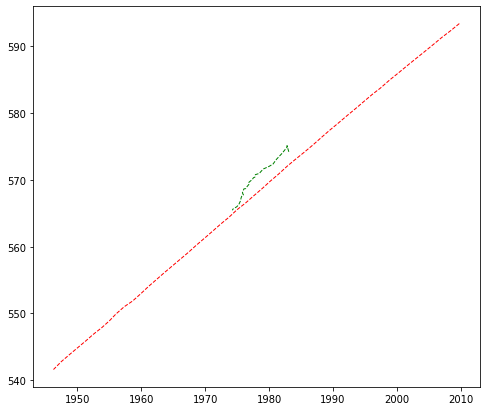

In [215]:
recovery(180)

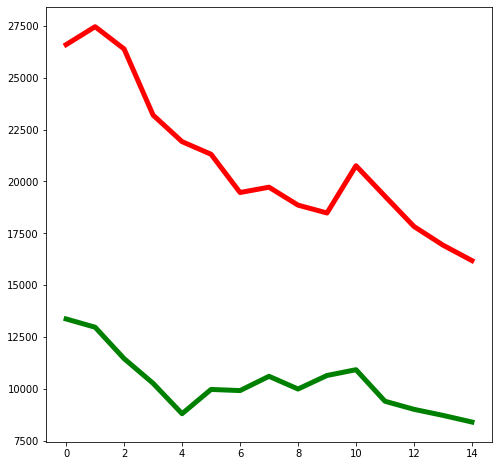

In [209]:
plt.figure(0, figsize=(8, 8))
plt.plot(range(len(TestingLoss)), TestingLoss, color="green", alpha=1,linewidth=5)
plt.plot(range(len(TrainingLoss)), TrainingLoss,  color="red", alpha=1,linewidth=5)